# Lauch this with C:\<dir>\jupyter-lab

In [1]:
ticker = "QQQ"
data_point = "Open" 
training_percent = 90

In [2]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

In [3]:
# Recurrent Neural Network

# Part 1 - Data Preprocessing

# Importing the training and test sets
file = ".\\Data\\" + ticker + ".csv"
df = pd.read_csv(file)

train_count = int(len(df) * (training_percent/100))
test_count = int(len(df) * ((100 - training_percent)/100))

dataset_train = df.head(train_count)
dataset_test = df.tail(test_count)

# '.values' need the 2nd Column Opening Price as a Numpy array (not vector)
# '1:2' is used because the upper bound is ignored
training_set = dataset_train.iloc[:, 1:2].values

# Feature Scaling
# Use Normalization (versus Standardization) for RNNs with Sigmoid Activation Functions
# 'MinMaxScalar' is a Normalization Library
from sklearn.preprocessing import MinMaxScaler
# 'feature_range = (0,1)' makes sure that training data is scaled to have values between 0 and 1
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps (look back 60 days) and 1 output
# This tells the RNN what to remember (Number of timesteps) when predicting the next Stock Price
# The wrong number of timesteps can lead to Overfitting or bogus results
# 'x_train' Input with 60 previous days' stock prices
X_train = []
# 'y_train' Output with next day's stock price
y_train = []

# 'rg' is the length of the training data.  this ensures we loop through all of the training data
rg = training_set_scaled.shape[0]

for i in range(60, rg):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping (add more dimensions)
# This lets you add more indicators that may potentially have corelation with Stock Prices
# Keras RNNs expects an input shape (Batch Size, Timesteps, input_dim)
# '.shape[0]' is the number of Rows (Batch Size)
# '.shape[1]' is the number of Columns (timesteps)
# 'input_dim' is the number of factors that may affect stock prices
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Show the dataset we're working with
display(dataset_train)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-03-10,51.125000,51.156250,50.281250,51.062500,44.011364,5232000
1,1999-03-11,51.437500,51.734375,50.312500,51.312500,44.226841,9688600
2,1999-03-12,51.125000,51.156250,49.656250,50.062500,43.149483,8743600
3,1999-03-15,50.437500,51.562500,49.906250,51.500000,44.388458,6369000
4,1999-03-16,51.718750,52.156250,51.156250,51.937500,44.765549,4905800
...,...,...,...,...,...,...,...
5355,2020-06-19,246.729996,247.000000,242.449997,244.240005,241.011719,49422100
5356,2020-06-22,243.679993,246.869995,243.380005,246.740005,243.902069,24068700
5357,2020-06-23,248.389999,251.149994,247.820007,248.839996,245.977951,32767400
5358,2020-06-24,248.059998,249.330002,242.160004,243.710007,240.906937,46032400


In [4]:
# Part 2 - Building the RNN
# Building a robust stacked LSTM with dropout regularization

# Initialising the RNN
# Regression is when you predict a continuous value
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# 'units' is the number of LSTM Memory Cells (Neurons) for higher dimensionality
# 'return_sequences = True' because we will add more stacked LSTM Layers
# 'input_shape' of x_train
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# 20% of Neurons will be ignored (10 out of 50 Neurons) to prevent Overfitting
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
# Not need to specify input_shape for second Layer, it knows that we have 50 Neurons from the previous layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
# This is the last LSTM Layer. 'return_sequences = false' by default so we leave it out.
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
# 'units = 1' because Output layer has one dimension
regressor.add(Dense(units = 1))

# Compiling the RNN
# Keras documentation recommends 'RMSprop' as a good optimizer for RNNs
# Trial and error suggests that 'adam' optimizer is a good choice
# loss = 'mean_squared_error' which is good for Regression vs. 'Binary Cross Entropy' previously used for Classification
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
# 'X_train' Independent variables
# 'y_train' Output Truths that we compare X_train to.
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
166/166 [==============================] - 16s 32ms/step - loss: 0.0049
Epoch 2/100
166/166 [==============================] - 4s 27ms/step - loss: 0.0014
Epoch 3/100
166/166 [==============================] - 4s 27ms/step - loss: 0.0013
Epoch 4/100
166/166 [==============================] - 5s 27ms/step - loss: 0.0012
Epoch 5/100
166/166 [==============================] - 4s 27ms/step - loss: 0.0011
Epoch 6/100
166/166 [==============================] - 5s 27ms/step - loss: 9.8647e-04
Epoch 7/100
166/166 [==============================] - 4s 26ms/step - loss: 9.7647e-04
Epoch 8/100
166/166 [==============================] - 4s 26ms/step - loss: 9.0717e-04
Epoch 9/100
166/166 [==============================] - 4s 27ms/step - loss: 9.2357e-04
Epoch 10/100
166/166 [==============================] - 4s 27ms/step - loss: 9.7870e-04
Epoch 11/100
166/166 [==============================] - 5s 29ms/step - loss: 8.5592e-04
Epoch 12/100
166/166 [==============================] - 5s 2

 3/19 [===>..........................] - ETA: 0s

C:\Users\WhyglePa\AppData\Local\Temp\ipykernel_3528\4085341819.py:12: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values


19/19 [==============================] - 1s 34ms/step
Mean Squared Error: 
83.75390823262468
Mean Absolute Error: 
75.24453266770612
R-Squared Score: 
-3.5123966849188393


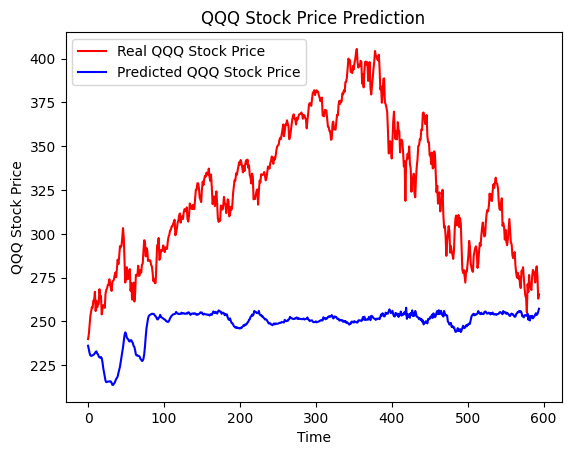

In [6]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price
real_stock_price = dataset_test.iloc[:, 1:2].values
#display(dataset_test)
# Getting the predicted stock price 
# We need 60 previous inputs for each day of the Test_set 
# Combine 'dataset_train' and 'dataset_test'
# 'axis = 0' for Vertical Concatenation to add rows to the bottom
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
# Extract Stock Prices for Test time period, plus 60 days previous
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
# 'reshape' function to get it into a NumPy format
inputs = inputs.reshape(-1,1)
# Inputs need to be scaled to match the model trained on Scaled Feature
inputs = sc.transform(inputs)
# The following is pasted from above and modified for Testing, romove all 'Ys'
X_test = []
y_test = []

# 'rg' is the length of the training data.  this ensures we loop through all of the training data
rg = inputs.shape[0]

for i in range(60, rg):
    X_test.append(inputs[i-60:i, 0])
    y_test.append(inputs[i, 0])

X_test = np.array(X_test)
# We need a 3D input so add another dimension
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Predict the Stock Price
predicted_stock_price = regressor.predict(X_test)
# We need to inverse the scaling of our prediction to get a Dollar amount
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

y_pred = []
rg = len(predicted_stock_price)
for i in range(0, rg):    
    y_pred.append(predicted_stock_price[i,0])

y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)
y_test = sc.inverse_transform(y_test)
#display(y_test)
#display(y_pred)

rms = metrics.mean_squared_error(y_test, predicted_stock_price , squared=False)
mae = metrics.mean_absolute_error(y_test, predicted_stock_price)
rse = metrics.r2_score(y_test, y_pred, multioutput='variance_weighted', force_finite=False)
print("Mean Squared Error: ")
print(rms)
print("Mean Absolute Error: ")
print(mae)
print("R-Squared Score: ")
print(rse)

# Visualising the results
plt.plot(real_stock_price, color = 'red', label = 'Real ' + ticker + ' Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted ' + ticker + ' Stock Price')
plt.title(ticker + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()
